In [1]:
import copy

import pandas as pd
import numpy as np
import optuna
import xgboost
import imblearn.over_sampling
import sklearn.model_selection
import dscribe.descriptors
import tqdm
import sklearn.pipeline

import functools

import matplotlib.pyplot as plt
import sklearn.impute
import seaborn as sns

import sys
sys.path.append("../../../")
import DigitalEcosystem.utils.figures

tqdm.tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
# Load up the data
data_path = "../../refined/httpot/full_featurized_data.pkl"
data = pd.read_pickle(data_path)

cols_to_drop = ['formula',
                'discovery_process (unitless)',
                'potcars (unitless)',
                'is_hubbard (unitless)',
                'energy_per_atom (eV)',
                'exfoliation_energy_per_atom (eV/atom)',
                'is_bandgap_direct (unitless)',
                'is_metal (unitless)',
                'energy_vdw_per_atom (eV/atom)',
                'total_magnetization (Bohr Magneton)']
matpedia_id = ['2dm_id (unitless)']
atoms_col = ['atoms_object (unitless)']

In [4]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]
matminer_descriptors = [
    'bond_length_average',
    'bond_angle_average',
    'average_cn',
    'global_instability',
    'perimeter_area_ratio',
    'ewald_energy_per_atom',
    'structural complexity per atom',
    'structural complexity per cell',
    'n_symmetry_ops'
]
xenonpy_matminer_descriptors = xenonpy_descriptors + matminer_descriptors

In [5]:
# Conversion factors from http://laser.chem.olemiss.edu/~nhammer/constants.html

data['exfoliation_energy (eV)'] = data['exfoliation_energy_per_atom (eV/atom)'] * data['atoms_object (unitless)'].apply(len)

J_per_eV = 1.60217733e-19
data['exfoliation_energy (J)'] = data['exfoliation_energy (eV)'] * J_per_eV

data['surface_area (A^2)'] = data['atoms_object (unitless)'].apply(lambda atoms: atoms.get_cell()).apply(lambda cell: np.linalg.norm(np.cross(cell[0], cell[1])))
m_per_A = 1e-10
data['surface_area (m^2)'] = data['surface_area (A^2)'] * (m_per_A**2)

data['exfoliation_energy (J/m^2)'] = data['exfoliation_energy (J)'] / data['surface_area (m^2)']

target_column = 'exfoliation_energy (J/m^2)'

In [6]:
noble_gases = ['He', 'Ne', 'Ar', 'Kr', 'Xe', 'Rn']
fblock = ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
          'Ac', 'Th', 'Pa', 'U',  'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']
d_synths = ['Rf', 'Db', 'Sg', 'Bh', 'HS', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']

bad_elements = noble_gases + fblock + d_synths

element_mask = data['atoms_object (unitless)'].apply(lambda atoms: all([forbidden not in atoms.get_chemical_symbols() for forbidden in bad_elements]))

decomp_mask = data['decomposition_energy (eV/atom)'] < 0.5

exfol_mask = data['exfoliation_energy_per_atom (eV/atom)'] > 0

reasonable = data[element_mask & decomp_mask & exfol_mask]

In [7]:
train, test = sklearn.model_selection.train_test_split(reasonable, test_size=0.1, random_state=RANDOM_SEED)

In [8]:
train_x_reg = np.nan_to_num(train[xenonpy_matminer_descriptors].to_numpy())
train_y_reg = np.nan_to_num(train[target_column].to_numpy())

test_x_reg = np.nan_to_num(test[xenonpy_matminer_descriptors].to_numpy())
test_y_reg = np.nan_to_num(test[target_column].to_numpy())

In [9]:
current_reg = None
best_reg = None
def keep_best_reg(study, trial):
    global best_reg
    if study.best_trial == trial:
        best_reg = current_reg

def objective(trial: optuna.Trial):
    global current_reg
    
    SEED = trial.suggest_categorical('random', [42,1234,12345])
    objective_train_x_reg, objective_validation_x_reg, objective_train_y_reg, objective_validation_y_reg = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x_reg), train_y_reg, test_size=0.25, random_state=SEED)

    current_reg = sklearn.pipeline.Pipeline([
        ("Scaler", sklearn.preprocessing.MinMaxScaler()),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(
            max_depth= trial.suggest_int('max_depth', 1, 50),
            min_child_weight= trial.suggest_float('min_child_weight', 0, 10),
            reg_alpha = trial.suggest_float('alpha', 0, 10),
            reg_lambda = trial.suggest_float('lambda', 0, 10),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0,1),
            subsample=trial.suggest_float('subsample', .1,1),
            learning_rate=trial.suggest_float('learning_rate', 0.001, 1),
            n_estimators=1000,
            objective='reg:pseudohubererror',
            random_state=SEED)),
    ])
    
#     pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-rmse')
    current_reg.fit(X=objective_train_x_reg, y=objective_train_y_reg,
                         **{
#                             'XGB_Regressor__eval_set': [[objective_validation_x_reg, objective_validation_y_reg]],
#                             'XGB_Regressor__eval_metric': 'rmse',
#                             'XGB_Regressor__early_stopping_rounds': 100,
#                             'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    score = sklearn.metrics.r2_score(
        y_true=objective_validation_y_reg,
        y_pred=abs(current_reg.predict(objective_validation_x_reg)),
    )

    return score

reg_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
#     pruner = optuna.pruners.HyperbandPruner(
#         min_resource=1,
#         max_resource=1000),
    direction='maximize'
)

reg_study.optimize(func=objective, n_trials=128, callbacks=[keep_best_reg])

[I 2021-08-27 17:55:34,619] A new study created in memory with name: no-name-d5fe93ab-8c78-4ae3-91f0-16fbfdfd3116
[I 2021-08-27 17:55:39,269] Trial 0 finished with value: 0.28936248070396364 and parameters: {'random': 1234, 'max_depth': 40, 'min_child_weight': 7.799758081188035, 'alpha': 2.7259260528264164, 'lambda': 2.764642551430967, 'colsample_bytree': 0.8018721775350193, 'subsample': 0.9623254183153347, 'learning_rate': 0.8760567021073526}. Best is trial 0 with value: 0.28936248070396364.
[I 2021-08-27 17:55:40,367] Trial 1 finished with value: 0.3936752314948032 and parameters: {'random': 12345, 'max_depth': 36, 'min_child_weight': 3.7025075479039495, 'alpha': 5.611961860656249, 'lambda': 5.030831653078097, 'colsample_bytree': 0.013768449590682241, 'subsample': 0.7955439594511367, 'learning_rate': 0.8827585494454805}. Best is trial 1 with value: 0.3936752314948032.
[I 2021-08-27 17:55:44,380] Trial 2 finished with value: 0.37658289143153734 and parameters: {'random': 1234, 'max_de

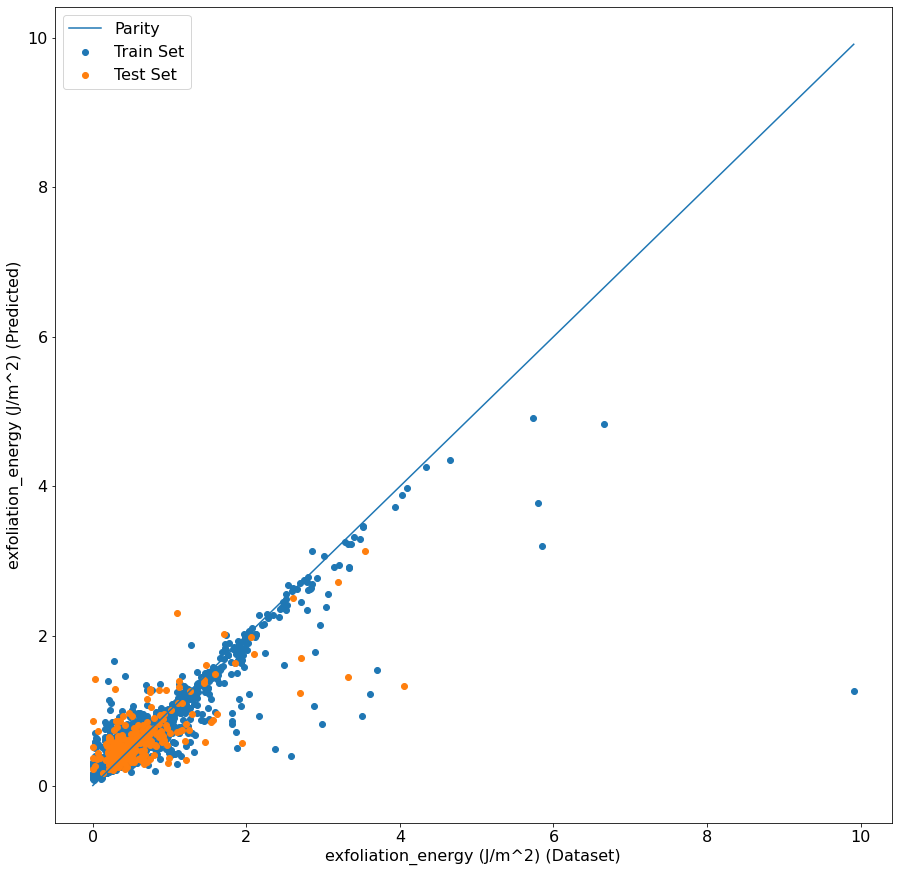

In [10]:
DigitalEcosystem.utils.figures.save_parity_plot(train_x_reg,
                                                test_x_reg,
                                                train_y_reg,
                                                test_y_reg,
                                                best_reg,
                                                target_column,
                                                "exfoliation_joules_per_meter.jpeg")

In [11]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

y_pred_test = best_reg.predict(test_x_reg)
for key, fun in metrics.items():
    value = fun(y_true=test_y_reg, y_pred=y_pred_test)
    print(key,np.round(value,3))

MaxError 2.72
MAE 0.19
MSE 0.112
RMSE 0.334
MAPE 4.834
R2 0.574
